# Project 5 - Vehicle Detection and Tracking

## Introduction

In this project, we apply Computer Vision to the task of vehicle detection and tracking on a video feed.

In [1]:
import os
import math
import cv2
import glob
import zipfile
import scipy
import pickle
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from IPython.display import display, HTML
from urllib.request import urlretrieve
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

## Tools and helper functions

In [26]:
def get_output_dir():
    output_dir = './output_images'
    
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    return output_dir

def save_plt_img(fig_handle, fname):
    plt.figure(fig_handle.number)
    plt.savefig(os.path.join(get_output_dir(), fname + '.jpg'))
    
def save_cv_img(img, fname):
    scipy.misc.imsave(os.path.join(get_output_dir(), fname + '.jpg'), img)
    
def read_img(fname):
    return scipy.misc.imread(fname)

## Data download and unpacking

In [3]:
vehicles_file = 'vehicles.zip'
non_vehicles_file = 'non-vehicles.zip'
download_url_base = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/'

In [4]:
def download(url):
    # Get file name
    file = url.rsplit('/', 1)[-1]
    
    # Download
    print('Downloading ' + file + '...')
    if not os.path.isfile(file):
        urlretrieve(url, file)
        print('Download Finished')
    else:
        print('File already in the filesystem!')
        
download(url = download_url_base + vehicles_file)
download(url = download_url_base + non_vehicles_file)

File already in the filesystem!
File already in the filesystem!


In [5]:
def unzip(file):
    if not os.path.isdir(os.path.splitext(file)[0]):        
        print('Unzipping ' + file + '...')
        with zipfile.ZipFile(file,"r") as zip_ref:
            zip_ref.extractall()
    else:
        print('File ' + file + ' already unpacked!')

unzip(vehicles_file)
unzip(non_vehicles_file)

File vehicles.zip already unpacked!
File non-vehicles.zip already unpacked!


## Data loading

In [6]:
def get_img_shape():
    return (64, 64, 3)

def get_vehicle_label():
    return 1

def get_non_vehicle_label():
    return 0

def load_dataset(class_base_folder, class_id):
    # Get filenames recursively
    f_names = glob.glob(class_base_folder + '/**/*.png')
    
    # Declare output arrays
    n_img = len(f_names)
    X = np.zeros((n_img,) + get_img_shape(), dtype = np.uint8)
    y = np.zeros((n_img,), dtype = int)
    
    # Read images and store them in memory
    for i in range(n_img):
        # Note: the input image is PNG, therefore a float32 array between 0.0 and 1.0
        X[i] = read_img(f_names[i])
        y[i] = class_id
        
    return X, y

print('Loading datasets...')
Img_v, y_v = load_dataset('vehicles', get_vehicle_label())
Img_nv, y_nv = load_dataset('non-vehicles', get_non_vehicle_label())
print('Done...')

Loading datasets...
Done...


In [7]:
print('Vehicle training data: ', Img_v.shape, y_v.shape)
print('Non-vehicle training data: ', Img_nv.shape, y_nv.shape)

Img = np.concatenate((Img_v, Img_nv))
y = np.concatenate((y_v, y_nv))

print('Combined dataset: ', Img.shape, y.shape)
print(np.amin(Img), np.amax(Img))

Vehicle training data:  (8792, 64, 64, 3) (8792,)
Non-vehicle training data:  (9666, 64, 64, 3) (9666,)
Combined dataset:  (18458, 64, 64, 3) (18458,)
0 255


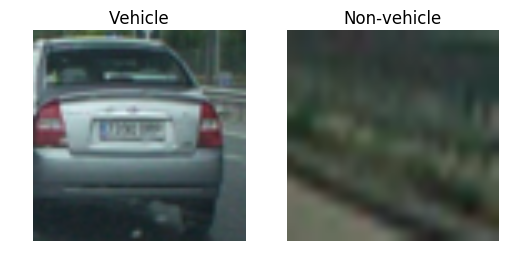

In [8]:
h = plt.figure()
plt.subplot(1,2,1);
plt.imshow(Img_v[0]);
plt.title('Vehicle');
plt.axis('off');
plt.subplot(1,2,2);
plt.imshow(Img_nv[0]);
plt.title('Non-vehicle');
plt.axis('off');

save_plt_img(fig_handle=h, fname='vehicle_non_vehicle')

## Data preprocessing

In [9]:
def rgb_to_ycrcb(Img):
    Img_out = np.copy(Img)
    for i in range(Img.shape[0]):
        Img_out[i] = cv2.cvtColor(Img[i], cv2.COLOR_RGB2YCrCb)
    
    return Img_out

Img_v_pp = rgb_to_ycrcb(Img_v)
Img_nv_pp = rgb_to_ycrcb(Img_nv)
Img_pp = rgb_to_ycrcb(Img)

## HOG feature extraction

In [10]:
def get_hog_features(img, debug = False):
    pix_per_cell = 8
    cell_per_block = 2
    orient = 9

    img_shape = img.shape
    n_channels = img_shape[2]
    
    features = []
    hog_image = np.zeros_like(img)
    
    for i in range(n_channels):
        if debug:
            features_i, hog_image[:, :, i] = hog(img[:, :, i], orientations=orient, 
                                                 pixels_per_cell=(pix_per_cell, pix_per_cell),
                                                 cells_per_block=(cell_per_block, cell_per_block),
                                                 visualise=True, feature_vector=True)
        else:
            features_i = hog(img[:, :, i], orientations=orient, 
                             pixels_per_cell=(pix_per_cell, pix_per_cell),
                             cells_per_block=(cell_per_block, cell_per_block),
                             visualise=False, feature_vector=True)
        features.append(features_i)

    features = np.array(features).ravel()
        
    if debug:        
        return features, hog_image
    else:
        return features

def get_hog_features_batch(Img):
    features = []
    for i in range(Img.shape[0]):
        features.append(get_hog_features(Img[i], debug=False))
    return np.array(features)

(5292,) float64 (64, 64, 3) uint8


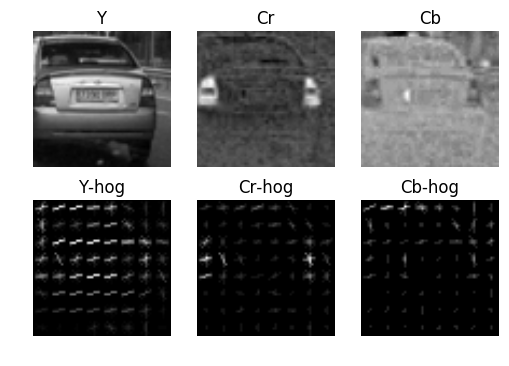

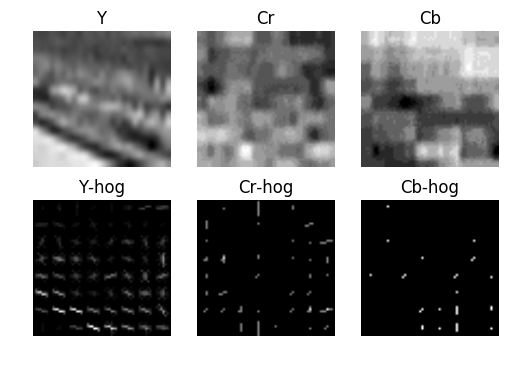

In [11]:
def test_hog_features():
    img_v = Img_v_pp[0]
    img_nv = Img_nv_pp[0]

    features_v, hog_image_v = get_hog_features(img_v, debug=True)
    features_nv, hog_image_nv = get_hog_features(img_nv, debug=True)

    print(features_v.shape, features_v.dtype, hog_image_v.shape, hog_image_v.dtype)

    h = plt.figure()
    img_labels = ['Y', 'Cr', 'Cb']

    for idx in range(3):
        plt.subplot(2,3, idx + 3 * 0 + 1);
        plt.imshow(img_v[:, :, idx], cmap='gray');
        plt.axis('off');
        plt.title(img_labels[idx]);

    for idx in range(3):
        plt.subplot(2,3, idx + 3 * 1 + 1);
        plt.imshow(hog_image_v[:, :, idx], cmap='gray');
        plt.axis('off');
        plt.title(img_labels[idx] + '-hog');        

    save_plt_img(fig_handle=h, fname='hog_img_vehicle')
        
    h = plt.figure()
    for idx in range(3):
        plt.subplot(2,3, idx + 3 * 0 + 1);
        plt.imshow(img_nv[:, :, idx], cmap='gray');
        plt.axis('off');
        plt.title(img_labels[idx]);
        
    for idx in range(3):
        plt.subplot(2,3, idx + 3 * 1 + 1);
        plt.imshow(hog_image_nv[:, :, idx], cmap='gray');
        plt.axis('off');
        plt.title(img_labels[idx] + '-hog');        
        
    save_plt_img(fig_handle=h, fname='hog_img_non_vehicle')        

test_hog_features()

In [12]:
features_file = 'features.pickle'

if not os.path.exists(features_file):
    print('Computing HOG features for the entire dataset...')
    X = get_hog_features_batch(Img_pp)
    print('Saving features into ' + features_file + '...')
    pickle.dump(X, open(features_file, 'wb'))
    print('Done')
else:
    print('Loading features from ' + features_file + '...')
    X = pickle.load(open(features_file, 'rb'))
    print('Done')
    
X = X.astype(np.float64)
print(X.shape)

Loading features from features.pickle...
Done
(18458, 5292)


## Dataset preparation

In [13]:
def normalize_features(X):
    X_scaler = StandardScaler().fit(X)    
    return X_scaler.transform(X)    

print('Normalizing features...')
X_norm = normalize_features(X)
print('Done')

Normalizing features...
Done


In [14]:
def split_validation(X, y):
    val_ratio = 0.2
    random_state = 918273645
    return train_test_split(X, y, test_size = val_ratio, random_state = random_state)

print('Splitting into train/validation set...')
X_train, X_val, y_train, y_val = split_validation(X_norm, y)

print('X_train: ', X_train.shape)
print('X_val: ', X_val.shape)

Splitting into train/validation set...
X_train:  (14766, 5292)
X_val:  (3692, 5292)


## Classifier Design

In [15]:
def define_classifier():
    svc = LinearSVC()
    return svc

classifier = define_classifier()

## Training

In [16]:
def train_classifier(classifier, X_train, y_train):
    classifier.fit(X_train, y_train)

print('Training classifier...')
train_classifier(classifier, X_train, y_train)
print('Done')

Training classifier...
Done


In [17]:
def save_classifier():
    raise NotImplemented

In [18]:
def load_classifier():
    raise NotImplemented

## Cross-validation

In [19]:
def compute_validation_accuracy(classifier, X_val, y_val):
    return classifier.score(X_val, y_val)
    
print('Validation accuracy: %.3f%%' % (100. * compute_validation_accuracy(classifier, X_val, y_val)))

Validation accuracy: 98.564%


## Test on single image

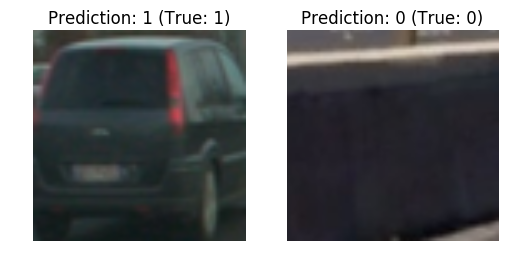

In [20]:
img_v_test = Img_v[np.random.randint(Img_v.shape[0])]
y_v_predicted = classifier.predict(normalize_features(get_hog_features(img_v_test)))

img_nv_test = Img_nv[np.random.randint(Img_nv.shape[0])]
y_nv_predicted = classifier.predict(normalize_features(get_hog_features(img_nv_test)))

h = plt.figure();
plt.subplot(1,2,1);
plt.imshow(img_v_test);
plt.title('Prediction: %d (True: %d)' % (y_v_predicted, get_vehicle_label()));
plt.axis('off');
plt.subplot(1,2,2);
plt.imshow(img_nv_test);
plt.title('Prediction: %d (True: %d)' % (y_nv_predicted, get_non_vehicle_label()));
plt.axis('off');

---
## Sliding Window Search

In [41]:
class SearchWindow:
    
    def __init__(self, x0, y0, size_x, size_y):
        self.x0 = x0
        self.y0 = y0
        self.size_x = size_x
        self.size_y = size_y  
        
    def get_img_contents(self, img):
        return img[self.y0 : self.y0 + self.size_y, 
                   self.x0 : self.x0 + self.size_x,
                   :]
    
    def draw_on_img(self, img):
        p1 = (self.x0,               self.y0)
        p2 = (self.x0,               self.y0 + self.size_y)
        p3 = (self.x0 + self.size_x, self.y0 + self.size_y)
        p4 = (self.x0 + self.size_x, self.y0)
        
        p = (p1, p2, p3, p4)
        
        color = (0, 0, 255)
        thickness = 2
        
        for i in range(4):
            cv2.line(img, p[i], p[(i+1) % 4], color = color, thickness = thickness)

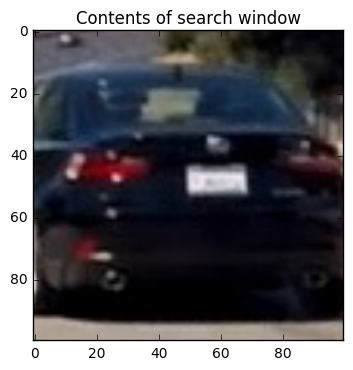

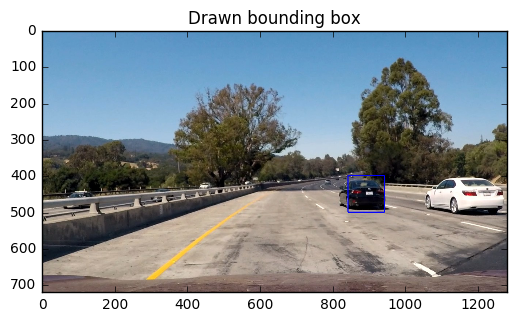

In [42]:
def test_get_img_contents():
    img = read_img('./test_images/test1.jpg')
    window = SearchWindow(840,400,100,100)
    plt.figure()
    plt.imshow(window.get_img_contents(img))
    plt.title('Contents of search window')    
    
def test_draw_on_img():
    img = read_img('./test_images/test1.jpg')
    window = SearchWindow(840,400,100,100)    
    window.draw_on_img(img)
    plt.figure()
    plt.imshow(img)
    plt.title('Drawn bounding box')        
    
test_get_img_contents()
test_draw_on_img()    

In [22]:
def get_search_windows(img_shape):
    raise NotImplemented

In [25]:
def draw_search_windows(img, windows):
    for w in windows:
        w.draw_on_img(img)

## Single Image pipeline

## Video pipeline

## Test on images

## Test on video